In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
warnings.simplefilter('ignore')

To load the hdmpy package which is used in the code below run the method below run from a jupyter notebook cell the code below
```
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git
```

In [2]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\cvxopt-1.3.2-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\cvxopt-1.3.2-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [3]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy

In [4]:
# An estimator class that runs the lasso with theoretically driven penalty choice.
# Better in small samples than cross-validation and also faster computationally
class RLasso(BaseEstimator):
    
    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    def predict(self, X):
        return X @ self.coef_ + np.array(self.rlasso_.est['intercept'])

In [5]:
# A simple experimental data generating process. No effect heterogeneity.
def gen_data(n, d, p, delta, base):
    X = np.random.normal(0, 1, size=(n, d))
    D = np.random.binomial(1, p, size=(n,))
    y0 = base - X[:, 0] + np.random.normal(0, .1, size=(n,))
    y1 = delta + base + X[:, 0] + np.random.normal(0, .1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X

In [6]:
n = 300 # n samples
d = 100 # n features
delta = 1.0 # treatment effect
base = .3 # baseline outcome

In [7]:
# Simple two means estimate and calcualtion of variance
def twomeans(y, D):
    hat0 = np.mean(y[D==0]) # mean of outcome of un-treated
    hat1 = np.mean(y[D==1]) # mean of outcome of treated
    V0 = np.var(y[D==0]) / np.mean(1 - D) # asymptotic variance of the mean of outcome of untreated
    V1 = np.var(y[D==1]) / np.mean(D) # asymptotic variance of the mean of outcome of treated
    hat = hat1 - hat0 # estimate of effect
    stderr = np.sqrt((V0 + V1) / n) # standard error of estimate of effect
    return hat, stderr

In [8]:
np.random.seed(123)
y, D, X = gen_data(n, d, .2, delta, base) # generate RCT data
twomeans(y, D) # calculate estimation quantities

(1.0160908141382419, 0.14663574871266533)

In [9]:
from sklearn.linear_model import LinearRegression
# We implement the partialling out version of OLS (for pedagogical purposes)
def partialling_out(y, D, W):
    yres = y - LinearRegression().fit(W, y).predict(W) # residualize outcome with OLS
    Dres = D - LinearRegression().fit(W, D).predict(W) # residualize treatment with OLS
    hat = np.mean(yres * Dres) / np.mean(Dres**2) # calculate final residual ~ residual ols estimate
    epsilon = yres - hat * Dres # calculate residual of final regression; epsilon in the BLP decomposition
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2 # calculate variance of effect
    return hat, np.sqrt(V / y.shape[0]) # return estimate and standard error

In [10]:
partialling_out(y, D, X - X.mean(axis=0))

(1.0244396322770404, 0.17245667979018192)

In [11]:
W = np.hstack([D.reshape(-1, 1) * X, X])
W = W - W.mean(axis=0)
partialling_out(y, D, W)

(1950165592495.495, 2947184683737.609)

In [12]:
# Now we simply replace OLS with Lasso to implement the Double Lasso process
def double_lasso(y, D, W):
    yres = y - RLasso().fit(W, y).predict(W) # residualize outcome with Lasso
    Dres = D - RLasso().fit(W, D).predict(W) # residualize treatment with Lasso
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])

In [13]:
double_lasso(y, D, W)

(0.9809556541813507, 0.028365049356534486)

In [14]:
# We now check the distributional properties of the different estimators across experiments
# First is the simple two means estimate
cov, hats, stderrs = [], [], [] # we will keep track of coverage (truth is in CI) and of the point estimate and stderr
for _ in range(100):
    y, D, X = gen_data(n, d, .2, delta, base)
    hat, stderr = twomeans(y, D)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval
    hats += [hat]
    stderrs += [stderr]
    cov += [(ci[0] <= delta) & (delta <= ci[1])] # 1 if CI contains the true parameter

In [15]:
np.mean(cov) # average coverage (should be .95 ideally)

0.91

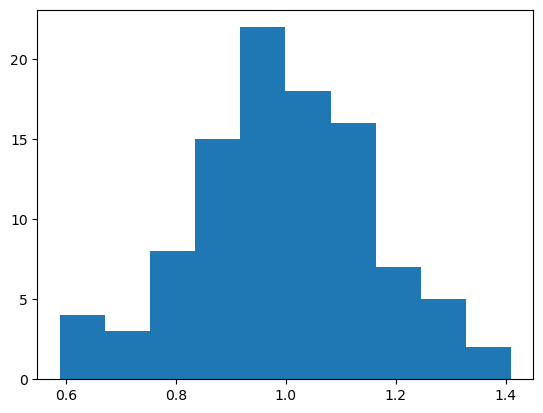

In [16]:
# distribution of estimates
plt.hist(hats)
plt.show()

In [17]:
np.mean(hats) # mean of estimate; measures how biased the estimate is (should be =delta ideally)

0.9941463393204567

In [18]:
np.std(hats) # standard deviation of estimates; should be close to the standard errors we calculated for the CIs

0.15860739734462548

In [19]:
np.mean(stderrs)

0.14596821476635413

In [20]:
# Let's repeat this for the partialling out process (OLS), controlling for X
cov, hats, stderrs = [], [], [] # we will keep track of coverage (truth is in CI) and of the point estimate and stderr
for _ in range(100):
    y, D, X = gen_data(n, d, .2, delta, base)
    hat, stderr = partialling_out(y, D, X)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval
    hats += [hat]
    stderrs += [stderr]
    cov += [(ci[0] <= delta) & (delta <= ci[1])] # 1 if CI contains the true parameter

In [21]:
np.mean(cov)

0.81

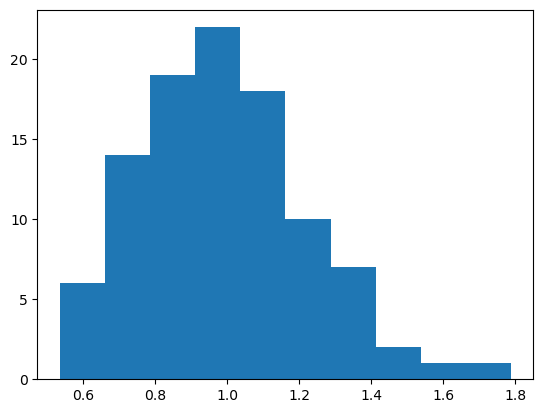

In [22]:
plt.hist(hats)
plt.show()

In [23]:
np.mean(hats) # ols is heavily biased... mean of estimates very far from delta=1

0.9831577389971592

In [24]:
np.std(hats)

0.23151104491213187

In [25]:
np.mean(stderrs) # standard error severely under estimates the variance of the estimate; all this is due to overfitting

0.15972811925123093

In [26]:
# Now let's try the double Lasso. Because it's computationally expensive
# we'll do the experiments in parallel. Python makes parallelism very simple
from joblib import Parallel, delayed # we import these two functions

# we wrap our experiment process in a function, which is supposed to run a
# a single experiment
def exp(it, n, d):
    np.random.seed(it) # we draw a different seed for each experiment
    y, D, X = gen_data(n, d, .2, delta, base) # we generate data
    X = X - X.mean(axis=0)
    hat, stderr = double_lasso(y, D, X) # we apply the double lasso process
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    # return estimate, standard error and (1 if CI contains the true parameter)
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

# Now here is how you run any function in parallel multiple times
# It's a simple parallel for loop.
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.6s finished


In [27]:
# This simply takes the list of triples and turns it into a triple of lists :)
# good trick to know
hats, stderrs, cov = zip(*res)

In [28]:
np.mean(cov) # much better coverage than OLS

0.955

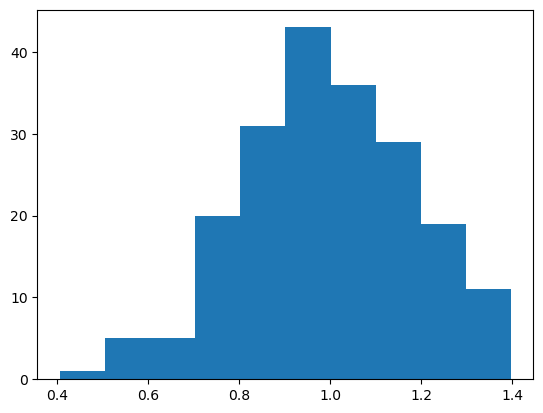

In [29]:
plt.hist(hats)
plt.show()

In [30]:
np.mean(hats) # much closer to 1... (almost the same as two-means)

0.9927125114441132

In [31]:
np.std(hats) # standard deviation much smaller than two means, which did not adjust for X

0.1889413322853059

In [32]:
np.mean(stderrs) # and close to the calculate standard errors; we correctly estimated uncertainty

0.18915121011787814

In [33]:
# Now let's try the double Lasso with interaction terms.
from joblib import Parallel, delayed # we import these two functions

# we wrap our experiment process in a function, which is supposed to run a
# a single experiment
def exp(it, n, d):
    np.random.seed(it) # we draw a different seed for each experiment
    y, D, X = gen_data(n, d, .2, delta, base) # we generate data
    W = np.hstack([D.reshape(-1, 1) * X, X])  # create interacted covariates
    W = W - W.mean(axis=0)  # de-mean the interacted covariates
    hat, stderr = double_lasso(y, D, W) # we apply the double lasso process
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    # return estimate, standard error and (1 if CI contains the true parameter)
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

# Now here is how you run any function in parallel multiple times
# It's a simple parallel for loop.
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   38.9s finished


In [34]:
# This simply takes the list of triples and turns it into a triple of lists :)
# good trick to know
hats, stderrs, cov = zip(*res)

In [35]:
np.mean(cov)

0.9

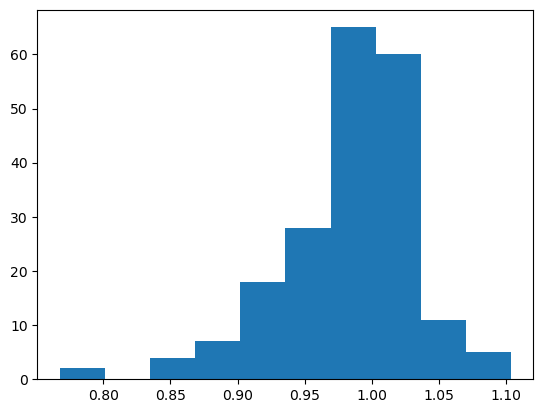

In [36]:
plt.hist(hats)
plt.show()

In [37]:
np.std(hats) # standard deviation much smaller than two means, which did not adjust for X

0.049623857862808415

In [38]:
np.mean(stderrs) # and close to the calculate standard errors; we correctly estimated uncertainty

0.036366384776244536

In [39]:
# Let's see what would happen if we just run a single lasso
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    hat = RLasso().fit(np.hstack([D.reshape(-1, 1), X]), y).coef_[0]
    return hat # no obvious way to account for uncertainty

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished


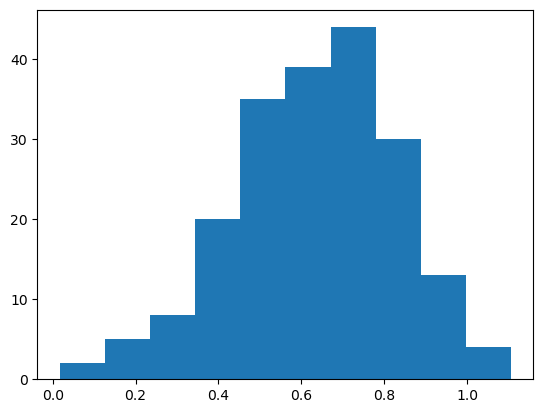

In [40]:
plt.hist(res)
plt.show()

In [41]:
# bias is comparable and larger than standard deviation.
# Even if we could estimate the standard deviation, confidence intervals would undercover
1 - np.mean(res), np.std(res)

(0.36716330268895037, 0.1993785366543265)

In [42]:
# Let's try adding a post-Lasso OLS step and construct confidence
# intervals ignoring the Lasso step
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    # run a big lasso y ~ D, X
    DX = np.hstack([D.reshape(-1, 1), X])
    coefs = RLasso().fit(DX, y).coef_[1:]
    # run OLS on y ~ D, X[chosen by lasso]
    # calculate standard error as if lasso step never happened
    hat, stderr = partialling_out(y, D - np.mean(D), X[:, np.abs(coefs)>0.0])
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.1s finished


In [43]:
hats, stderrs, cov = zip(*res)

In [44]:
np.mean(cov) # not bad

0.93

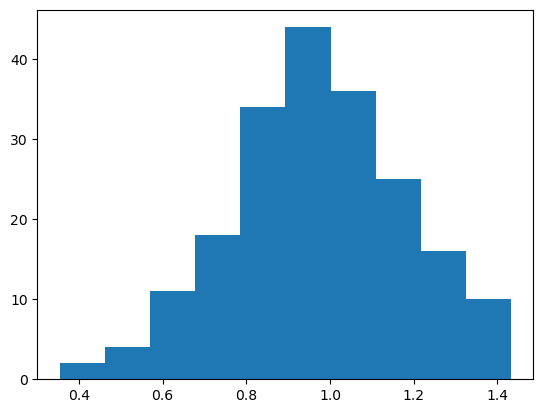

In [45]:
plt.hist(hats)
plt.show()

In [46]:
1 - np.mean(hats), np.std(hats) # quite un-biased; bias < standard deviation

(0.026060861223307752, 0.2085733751059216)

In [47]:
# we under-estimated a bit the uncertainty; smaller estimated stderr than true std. 
# this is most prob a finite sample error, from ignoring the lasso variable selection step
# this is an RCT and so even post lasso ols is Neyman orthogonal. We should expect good behavior.
np.mean(stderrs)

0.19262622767024745

In [48]:
# But what if we are not in an RCT!?
import scipy.special
def gen_data(n, d, p, delta, base):
    X = np.random.normal(0, 1, size=(n, d))
    D = X[:, 0] + np.random.normal(0, 1/4, size=(n,))
    y = delta * D + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    return y, D, X

In [49]:
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    DX = np.hstack([D.reshape(-1, 1), X])
    coefs = RLasso().fit(DX, y).coef_[1:]
    nonzero = np.abs(coefs)>0.0
    if np.sum(nonzero) > 0:
        hat, stderr = partialling_out(y, D, X[:, nonzero])
    else:
        hat, stderr = partialling_out(y, D, np.ones((D.shape[0], 1)))
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.1s finished


In [50]:
hats, stderrs, cov = zip(*res)

In [51]:
np.mean(cov) # Oops! Post Lasso OLS severely undercovers; It is not Neyman orthogonal when D is correlated with X

0.015

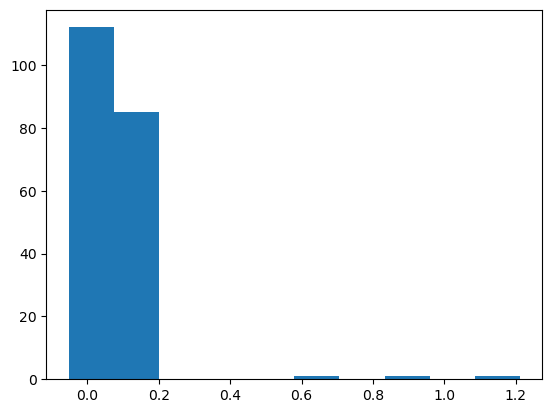

In [52]:
plt.hist(hats)
plt.show()

In [53]:
np.mean(hats) # very heavily biased

0.07362058052066309

In [54]:
# But let's try the Neyman orthogonal Double Lasso
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    X = X - X.mean(axis=0)
    hat, stderr = double_lasso(y, D, X) # we apply the double lasso process
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished


In [55]:
np.mean(cov) # great coverage

0.96

In [56]:
1 - np.mean(hats), np.std(hats) # very small bias compared to standard deviation

(0.024631448366620012, 0.22457066665262054)

In [57]:
np.mean(stderrs) # accurate estimation of uncertainty

0.22774630296255594

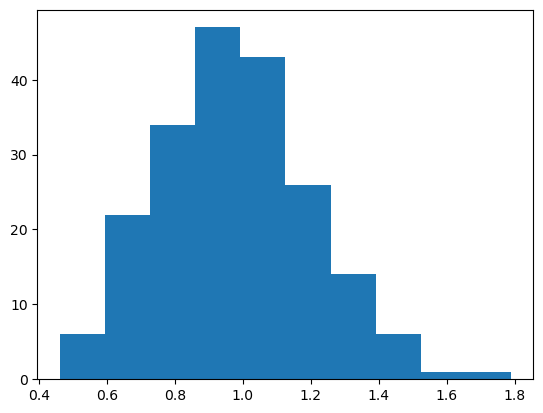

In [58]:
# Approximately normal distribution of estimates, centered at the truth
plt.hist(hats)
plt.show()